**Isaias Chavarria Mora**

**Model**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import glob
from collections import defaultdict
import os
from itertools import combinations
import csv
import gc
import matplotlib.pyplot as plt

In [2]:
BASE_PATH_DIRECTORY = ".." + os.sep + "train"
TEST_BASE_PATH_DIRECTORY = ".." + os.sep + "test"
SUBMISSIONS_RESULTS_FILE_NAME = ".." + os.sep + 'result_submissions.csv'
SUBMISSIONS_SAMPLE_FILE_NAME = ".." + os.sep + 'sample_submission.csv'
TRAINING_DATA_COMPLETED_FILE = ".." + os.sep + 'training_data_ready_for_nn_large.csv'

In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),#224,224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"WORKING ON {device} ")


WORKING ON cuda:0 


In [49]:
class ImagePairDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #0 = "P1"
        #1 = "P2"
        #2 = "result"
        
        P1_path = str(self.data.iloc[idx, 0])
        P2_path = str(self.data.iloc[idx, 1])
        label = self.data.iloc[idx, 2]

        P1_image = Image.open(P1_path).convert('RGB')
        P2_image = Image.open(P2_path).convert('RGB')
        if self.transform:
          P1_image = self.transform(P1_image)
          P2_image = self.transform(P2_image)
          
        return P1_image, P2_image, torch.tensor(label, dtype=torch.float32)

In [50]:
class RelationshipNetwork(nn.Module):
    def __init__(self):
        super(RelationshipNetwork, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove final classification layer
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            #nn.Linear(2048, 512),
            nn.ReLU(),
            #nn.Linear(512, 1),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        return self.resnet(x)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        distance = torch.abs(output1 - output2)
        out = self.fc(distance)
        return out

In [51]:
def load_dataset(csv_file, batch_size=32):
    dataset = ImagePairDataset(csv_file, transform=transform)
    #return DataLoader(dataset, batch_size=batch_size, num_workers=4, pin_memory=True) #, collate_fn=collate_fn)
    return DataLoader(dataset, batch_size=batch_size) #, collate_fn=collate_fn)

In [52]:
# dataset = ImagePairDataset(TRAINING_DATA_COMPLETED_FILE, transform=transform)
# print(len(dataset))
# print(dataset.__getitem__(50))
# print("ImagePairDataset OK")

**TEST MODEL**

In [4]:
#Read the submissions image pairs
submission_data = pd.read_csv(SUBMISSIONS_SAMPLE_FILE_NAME)
submission_data['p1'] = submission_data.img_pair.apply( lambda x: TEST_BASE_PATH_DIRECTORY + os.sep + x.split('-')[0])
submission_data['p2'] = submission_data.img_pair.apply( lambda x: TEST_BASE_PATH_DIRECTORY + os.sep + x.split('-')[1] )
print(submission_data.shape)
submission_data.head()

(5310, 4)


,img_pair,is_related,p1,p2
0,face05508.jpg-face01210.jpg,0,..\test\face05508.jpg,..\test\face01210.jpg
1,face05750.jpg-face00898.jpg,0,..\test\face05750.jpg,..\test\face00898.jpg
2,face05820.jpg-face03938.jpg,0,..\test\face05820.jpg,..\test\face03938.jpg
3,face02104.jpg-face01172.jpg,0,..\test\face02104.jpg,..\test\face01172.jpg
4,face02428.jpg-face05611.jpg,0,..\test\face02428.jpg,..\test\face05611.jpg


In [54]:
def test_model_images(model: torch.nn.Module, P1: str, P2: str):
    with torch.no_grad():
        P1_image = transform(Image.open(P1).convert('RGB')).unsqueeze(0).to(device)
        P2_image = transform(Image.open(P2).convert('RGB')).unsqueeze(0).to(device)
        output = model(P1_image, P2_image)
        return output.item()

In [55]:
def perform_test_process(model: torch.nn.Module):
    print("TEST PROCESS STARTED********")
    with open(SUBMISSIONS_RESULTS_FILE_NAME, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['img_pair', 'result'])
        for ind in submission_data.index:
            image1_path = submission_data["p1"][ind]
            image2_path = submission_data["p2"][ind]
            result = test_model_images(model, image1_path, image2_path)
            image_pair = image1_path + " - " + image2_path
            csvwriter.writerow([image_pair, str(result)])
    print("TEST PROCESS COMPLETED!!")

In [56]:
def create_loss_plot(loss_values):
    plt.plot(loss_values)
    plt.show()

In [57]:
# Training the model

def train_model(model: torch.nn.Module, dataloader:torch.utils.data.DataLoader, criterion: torch.nn.modules.loss, optimizer: torch.optim.Optimizer, num_epochs=10):
    try:
        model = model.to(device)
        # Prepare the model for training
        torch.cuda.empty_cache()
        gc.collect()
        model.train()
        num_samples = len(dataloader.dataset)
        num_batches = len(dataloader)
        print(f"TRAINING PROCESS STARTED for {num_epochs} EPOCHS")
        for epoch in range(num_epochs):
            counter =0
            epoch_loss = 0.0
            epoch_accuracy = 0.0
            for P1_image, P2_image, label in dataloader:
                counter = counter + 1
                P1_image, P2_image, label = P1_image.to(device), P2_image.to(device), label.to(device)
                
                
                optimizer.zero_grad()
                
                outputs = model(P1_image, P2_image)
                #loss = criterion(outputs.squeeze(), label)
                loss = criterion(outputs.squeeze(), label)

                epoch_loss += loss.item()
                #epoch_accuracy += (torch.argmax(outputs.data, 1) == label).sum().item()

                loss.backward()
                optimizer.step()

                if(counter % 5000 == 0):
                    print(f"Progress on {counter} batches")

            print(f'Epoch [{epoch + 1}/{num_epochs}], Epoch Loss: {epoch_loss / num_batches}')
            loss_vals.append(epoch_loss / num_batches)
    except Exception as e:
        print(f"An error occurred: {e}")
    
    torch.save({'epoch':epoch, 'model_state_dict': model.state_dict(),'optimizer_state_dict':optimizer.state_dict(), 'loss':loss.item()},f'model_RESNET.pth')
    # Test the model
    perform_test_process(model)

In [58]:
# Paths and constants
batch_size = 32
num_epochs = 14
learning_rate = 0.00001

# Initialize model, criterion, optimizer
model = RelationshipNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Load data
dataloader = load_dataset(TRAINING_DATA_COMPLETED_FILE, batch_size)
print("Dataset Loaded Correctly!!")
# Train the model
loss_vals = []
train_model(model, dataloader, criterion, optimizer, num_epochs)


c:\Users\isaia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\isaia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dataset Loaded Correctly!!
TRAINING PROCESS STARTED for 14 EPOCHS
Progress on 5000 batches
Progress on 10000 batches
Epoch [1/14], Epoch Loss: 0.18849752010884194
Progress on 5000 batches
Progress on 10000 batches
Epoch [2/14], Epoch Loss: 0.15097177997737285
Progress on 5000 batches
Progress on 10000 batches
Epoch [3/14], Epoch Loss: 0.11742385026746854
Progress on 5000 batches
Progress on 10000 batches
Epoch [4/14], Epoch Loss: 0.08187762373364696
Progress on 5000 batches
Progress on 10000 batches
Epoch [5/14], Epoch Loss: 0.05465182321318164
Progress on 5000 batches
Progress on 10000 batches
Epoch [6/14], Epoch Loss: 0.04065806125908529
Progress on 5000 batches
Progress on 10000 batches
Epoch [7/14], Epoch Loss: 0.032226017568185
Progress on 5000 batches
Progress on 10000 batches
Epoch [8/14], Epoch Loss: 0.031227927343564568
Progress on 5000 batches
Progress on 10000 batches
Epoch [9/14], Epoch Loss: 0.02963370956846256
Progress on 5000 batches
Progress on 10000 batches
Epoch [10/1

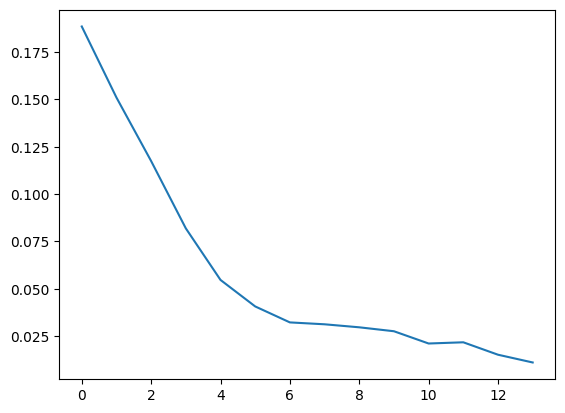

In [59]:
create_loss_plot(loss_values=loss_vals)